# Visualize Galileo Magnetometer data with pyWWT

This notebook uses the PDS Search API to visualize Galileo Orbiter's magnetosphere measurement campaign with pyWWT. Thanks to PyWWT observations are displayed in their Solar System location in a 3D view.

To properly run this code, ensure that you have followed the steps outlined in the README.md file. Additionally, ensure that you have opened an "AAS Worldwide Telescope" launcher in your notebook work space. To do this simply go to File -> New Launcher and (if configured correctly) click the AAS WWT icon. See [WWTs Jupyter Application](https://pywwt.readthedocs.io/en/stable/jupyterlab.html) for troubleshooting and further setup.


## Step 0: Import Libraries and download pds4_tools

In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np

import requests
import spiceypy
import os
import io
import pds4_tools

from datetime import datetime,timedelta
import matplotlib.dates as mdates
from astropy import units as u

from astropy.time import Time
from pywwt.jupyter import WWTJupyterWidget
from pywwt.jupyter import connect_to_app
from astropy.table import Table, hstack
import matplotlib.pyplot as plt

## Step 1: Extract data from the PDS Search API

### Get the observational products of a Galileo Magnetometer collection

Utilize the PDS Search API to list the magnetometer observational products of a Galileo Orbiter's collection in a pandas dataframe.


First step: 
- Grab the LID and apply it to URL

In [3]:
#Low-res magnetometer data
collection_lid = "urn:nasa:pds:galileo-mag-jup-calibrated:data-magspheric-survey::1.0"
url = f"https://pds.nasa.gov/api/search/1/products/{collection_lid}/members"

Second Step:
- Apply parameters that we would like to obtain from each product

In [4]:
field_names = [ "lid", "vid", "pds:Time_Coordinates.pds:start_date_time",
    "pds:Time_Coordinates.pds:stop_date_time", "pds:Target_Identification.pds:name",
    "ops:Label_File_Info.ops:file_ref"]

params = dict(
    fields = ",".join(field_names)
)

headers = dict(Accept="application/csv")

Third Step:
- Use python requests with parameters and header to grab the products!

In [5]:
response = requests.get(
    url,
    params=params,
    headers=headers
)

In [6]:
response

<Response [200]>

Now use python libraries to read the CSV data and put it into a pandas data frame for further manipulation

Use the start_time and end_time variables to adjust the time frame query!

In [7]:
products_csv_stream = io.StringIO(response.content.decode('utf-8'))
products_df_tot = pd.read_csv(products_csv_stream)

# change columns & line order
products_df_tot = products_df_tot[field_names]
products_df_tot.sort_values(by='pds:Time_Coordinates.pds:start_date_time', inplace=True)

#User specified time range
start_time = pd.to_datetime('1996-07-19T11:00:00Z')
end_time = pd.to_datetime('1997-08-19T15:00:00Z')

# Filter the DataFrame within the time range
t_str = 'pds:Time_Coordinates.pds:start_date_time'
products_df = products_df_tot[(pd.to_datetime(products_df_tot[t_str]) >= start_time) & (pd.to_datetime(products_df_tot[t_str]) <= end_time)]

### Display the list of products

In [8]:
display(products_df)

,lid,vid,pds:Time_Coordinates.pds:start_date_time,pds:Time_Coordinates.pds:stop_date_time,pds:Target_Identification.pds:name,ops:Label_File_Info.ops:file_ref
65,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
7,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
6,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
5,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:48.392Z,1996-11-02T11:44:09.104Z,"[Jupiter, Ganymede]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
67,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
68,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
69,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
66,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:57.095Z,1996-12-14T23:59:00.842Z,"[Jupiter, Callisto]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
8,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-12-15T00:18:32.842Z,1997-01-07T23:21:33.122Z,"[Jupiter, Europa]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...
31,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-12-15T00:18:32.842Z,1997-01-07T23:21:33.122Z,"[Jupiter, Europa]",[https://pds-ppi.igpp.ucla.edu/data/galileo-ma...


### Utilize pds4_tools utility to load each observational product dataset.

In the collection, observational products in 2 coordinate systems are proposed (`sys3` or `irc`). We only select the observational products using the `irc` coordinate system.

In [10]:
xml_urls = [xml_url.strip('[]') for xml_url in products_df['ops:Label_File_Info.ops:file_ref'] if 'IRC' in xml_url]
layer_names = [xml_url[85:] for xml_url in xml_urls]

data_dict = {}
for ind,xml_url in enumerate(xml_urls):
    prod_struct = pds4_tools.read(xml_url, quiet = True)
    data_dict[ind] = np.array(prod_struct[0]['SAMPLE TIME', 'B-FIELD MAGNITUDE'])

### Plot magnetic field magnitude time series

/var/folders/mw/1y5l8kz55h94xvjy67f2v8rh0000gp/T/ipykernel_13992/2015348506.py:14: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pyl

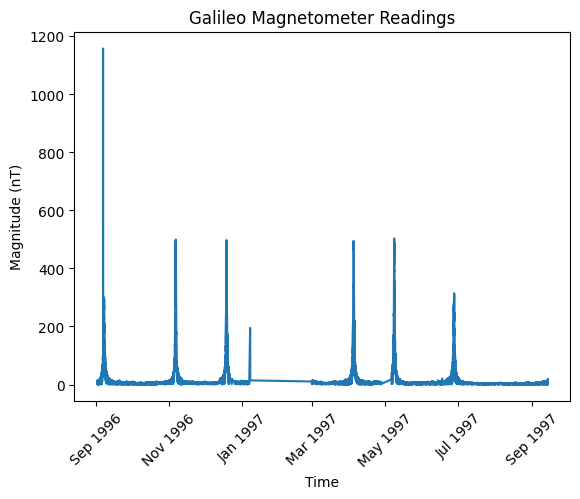

In [11]:
#put data into a single array
combined_data = [item for sublist in data_dict.values() for item in sublist]
mag_times = [data[0] for data in combined_data]
mag_measurements = [data[1] for data in combined_data]

mag_datetime = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in mag_times]
fig, ax = plt.subplots()
cm = ax.plot(mag_datetime,mag_measurements)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel("Time")
plt.locator_params(axis='x', nbins=10)
plt.ylabel("Magnitude (nT)")
plt.title("Galileo Magnetometer Readings")

plt.show()

## Step 2: Obtain ephemeris for magnetometer measurements

Obtain the position at each magnetometer measurement timestamp using spiceypy.

***Note: You can change the number of data points you would like to plot by changing the sample variable. The higher it is, the fewer data points you will plot.***

### Load Spice Kernels

Spice kernels are used to compute the location of the spacecraft at given date/time.

In [12]:
def download_and_load_spice_kernel(p_url):
    if not os.access('.spice_kernels',os.F_OK):
        os.mkdir('.spice_kernels')

    kernel_dir = os.path.join(".spice_kernels")
    os.makedirs(kernel_dir, exist_ok=True)
    file_path = os.path.join(kernel_dir, os.path.basename(p_url))
    if not os.path.exists(file_path):
        r = requests.get(url, allow_redirects=True)
        if r.status_code == 200:
            print('Successfully loaded:',os.path.basename(p_url))

            open(file_path, "wb").write(r.content)
    else:
        print('"',os.path.basename(p_url), '" already exists. Skipping download.')
    spiceypy.furnsh(file_path)
    
KERNEL_URLS = [
    #generic LSK
    "https://naif.jpl.nasa.gov/pub/naif/pds/data/ody-m-spice-6-v1.0/odsp_1000/data/lsk/naif0008.tls",
    #Galileo SC SPK
    "https://naif.jpl.nasa.gov/pub/naif/GLL/kernels/spk/gll_951120_021126_raj2021.bsp",
    # Leap seconds kernel
    "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls",
]
for url in KERNEL_URLS:
    download_and_load_spice_kernel(url)
            


" naif0008.tls " already exists. Skipping download.
" gll_951120_021126_raj2021.bsp " already exists. Skipping download.
" naif0012.tls " already exists. Skipping download.


### Compute spacecraft position for each magnetometer measurement.

In [14]:
sample = 100
trunc_data_tot = combined_data[1::sample]

mag_ephem_data = []
mag_dict = {}
for ind, data in data_dict.items():
    mag_ephem_data = []
    for t in data_dict[ind]['SAMPLE TIME'][0::sample]:
            et = spiceypy.str2et( t )
            [state, ltime] = spiceypy.spkezr( '5', et, 'J2000', 'LT+S', '-77')
            mag_ephem_data.append(state[0:3])
    mag_ephem_conv = np.array(mag_ephem_data)
    mag_dict[ind] = hstack([Table(data_dict[ind][0::sample]), Table(mag_ephem_conv, names = ['X', 'Y', 'Z'])] )

print("Number of magnetometer readings to plot: "+ str(len(mag_ephem_data)))


Number of magnetometer readings to plot: 4542


## Step 4: display data in pyWWT Solar System 3D view

### Connect pyWWT Widget

***Before proceeding, ensure that you have another tab open in the notebook for the AAS WorldWide Telescope widget***

Instantiate the WWTJupyterWidget and await connection.

In [15]:
wwt = WWTJupyterWidget()
wwt = await connect_to_app().becomes_ready()
print('Successful Connection')
wwt.reset()

Successful Connection


### Load data into pyWWT window

Set the WWT view to the solar system and load in the magnetometer data and ephemeris data via table layers. Once complete, in the pyWWT widget the view will be centered on Jupiter. Zoom in to see the results!

In [16]:
wwt.set_current_time(Time('1995-12-07 15:21:01.776000'))
wwt.set_view("solar system")

#Visualize planetary orbit lines/paths
wwt.solar_system.orbits = False

for ind, table_data in mag_dict.items():
    layer = wwt.layers.add_table_layer(table = table_data, frame = 'jupiter',
                                      coord_type = 'rectangular',
                                      x_att = 'X', y_att = 'Y', z_att = 'Z', id = layer_names[ind])
    layer.xyz_unit = 'km'
    layer.far_side_visible = True

    layer.cmap_att = 'B-FIELD MAGNITUDE'
    layer.cmap.vmin = min(table_data['B-FIELD MAGNITUDE'])
    layer.cmap.vmax = max(table_data['B-FIELD MAGNITUDE'])

    layer.size_scale = 250
    layer.far_side_visible = True
    layer.marker_type = 'point'
    layer.opacity = 0.25

    # layer.name = "name"

    layer.marker_scale = 'world'

### Set view point on Jupiter
If this doesn't work the first time simply rerun the cell. 


In [18]:
wwt.solar_system.track_object('Jupiter')

### Animation (Work In Progress)

Note the below code is still a work in progress and will not function as intended.

In [15]:
# start_time = ephem_tab['Time'][0]
# theta_dot = 1.76**-4 *3600 # rad/hour
# thetas = [theta_dot * (datetime.fromisoformat(start_time) - datetime.fromisoformat(curr_time)).total_seconds()/3600 for curr_time in ephem_tab['Time']]

# trans_mat = [np.array([[np.cos(theta), -np.sin(theta)] , [np.sin(theta), np.cos(theta)]]) for theta in thetas]

# trans_xy = [np.dot(trans_mat,np.array([[x] , [y]])) for x,y in zip(ephem_tab['X'],ephem_tab['Y'])]

# for i in range(len(ephem_tab)):
#     trans_mat = [np.array([np.cos(thetas[i]), -np.sin(thetas[i])] , [np.sin(thetas[i]), np.cos(thetas[i])])]
#     trans_xy[i] = [np.dot(trans_mat,np.array([x] , [y])) for x,y in zip(ephem_tab['X'][i],ephem_tab['Y'])[i]]
   

eph.time_series = True
eph.time_att = 'Time'
eph.time_decay = 500 * u.hour

# layer.time_series = True
# layer.time_att = 'Time'
# layer.time_decay = 10000 * u.hour

my_time = Time('1996-12-07 15:21:01.776000')
wwt.set_current_time(my_time)

wwt.play_time(rate=10000)


NameError: name 'eph' is not defined

In [ ]:
wwt.pause_time()